In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import string
import re
import nltk
from matplotlib import pyplot as plt
import seaborn as sn

In [2]:
#load word vectorization model
import gensim.downloader
print(list(gensim.downloader.info()["models"].keys()))
word2vec = gensim.downloader.load("glove-wiki-gigaword-50")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']
Num GPUs Available:  1


In [3]:
# read flight data 
df = pd.read_csv("data/disaster_response_messages_training.csv")


train_text = df["message"]
wordCountPreFilter = len(train_text)


train_label = df[df.columns[7:]]

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# maximal length of included words (also determines the amount of zero padding)
MAXLEN = 40

# Preprocessing functions
def remove_punctuation(text):
    return "".join([i for i in text if i not in string.punctuation])

def tokenitzation(text):
    return re.split("\W+", text)

def remove_empty(text):
    return [word for word in text if word]

stopwords = nltk.corpus.stopwords.words("english")
def remove_stopwords(text):
    return [word for word in text if word not in stopwords]

def vectorization(text):
    res = []
    for word in text:
        try:
            res.append(word2vec[word])
        except:
            res.append(np.zeros(50))
    # zero padding
    for _ in range(len(res), MAXLEN):
        res.append(np.zeros(50))
    return np.array(res)

def preprocess(text):
    # remove punctuation
    text = remove_punctuation(text)
    # remove uppercase
    text = text.lower()
    # tokenize
    text = tokenitzation(text)
    # remove empty strings
    text = remove_empty(text)
    #remove stopwords
    text = remove_stopwords(text)
    return text
    
# filtering unwanted words
def filter_words(texts, labels):
    filtered_texts = []
    filtered_labels = []
    for i,text in enumerate(texts):
        # add text and label to the arrays 
        if len(text) > 0 and len(text) < MAXLEN:
            filtered_texts.append(text)
            filtered_labels.append(np.array(labels.iloc[[i]])[0])
            
    return filtered_texts, filtered_labels


#prepare data with one function(mostly for test and validation set, since I want to make plots 
# with the training set)
def prepare_data(text, labels):
    text = text.apply(preprocess)
    text, labels = filter_words(text, labels)
    text = [vectorization(sen) for sen in text]
    return np.array(text), np.array(labels)

min amount of words: 1
max amount of words: 39
median amount of words: 12.0
sentences: 20775
filtered words: 271


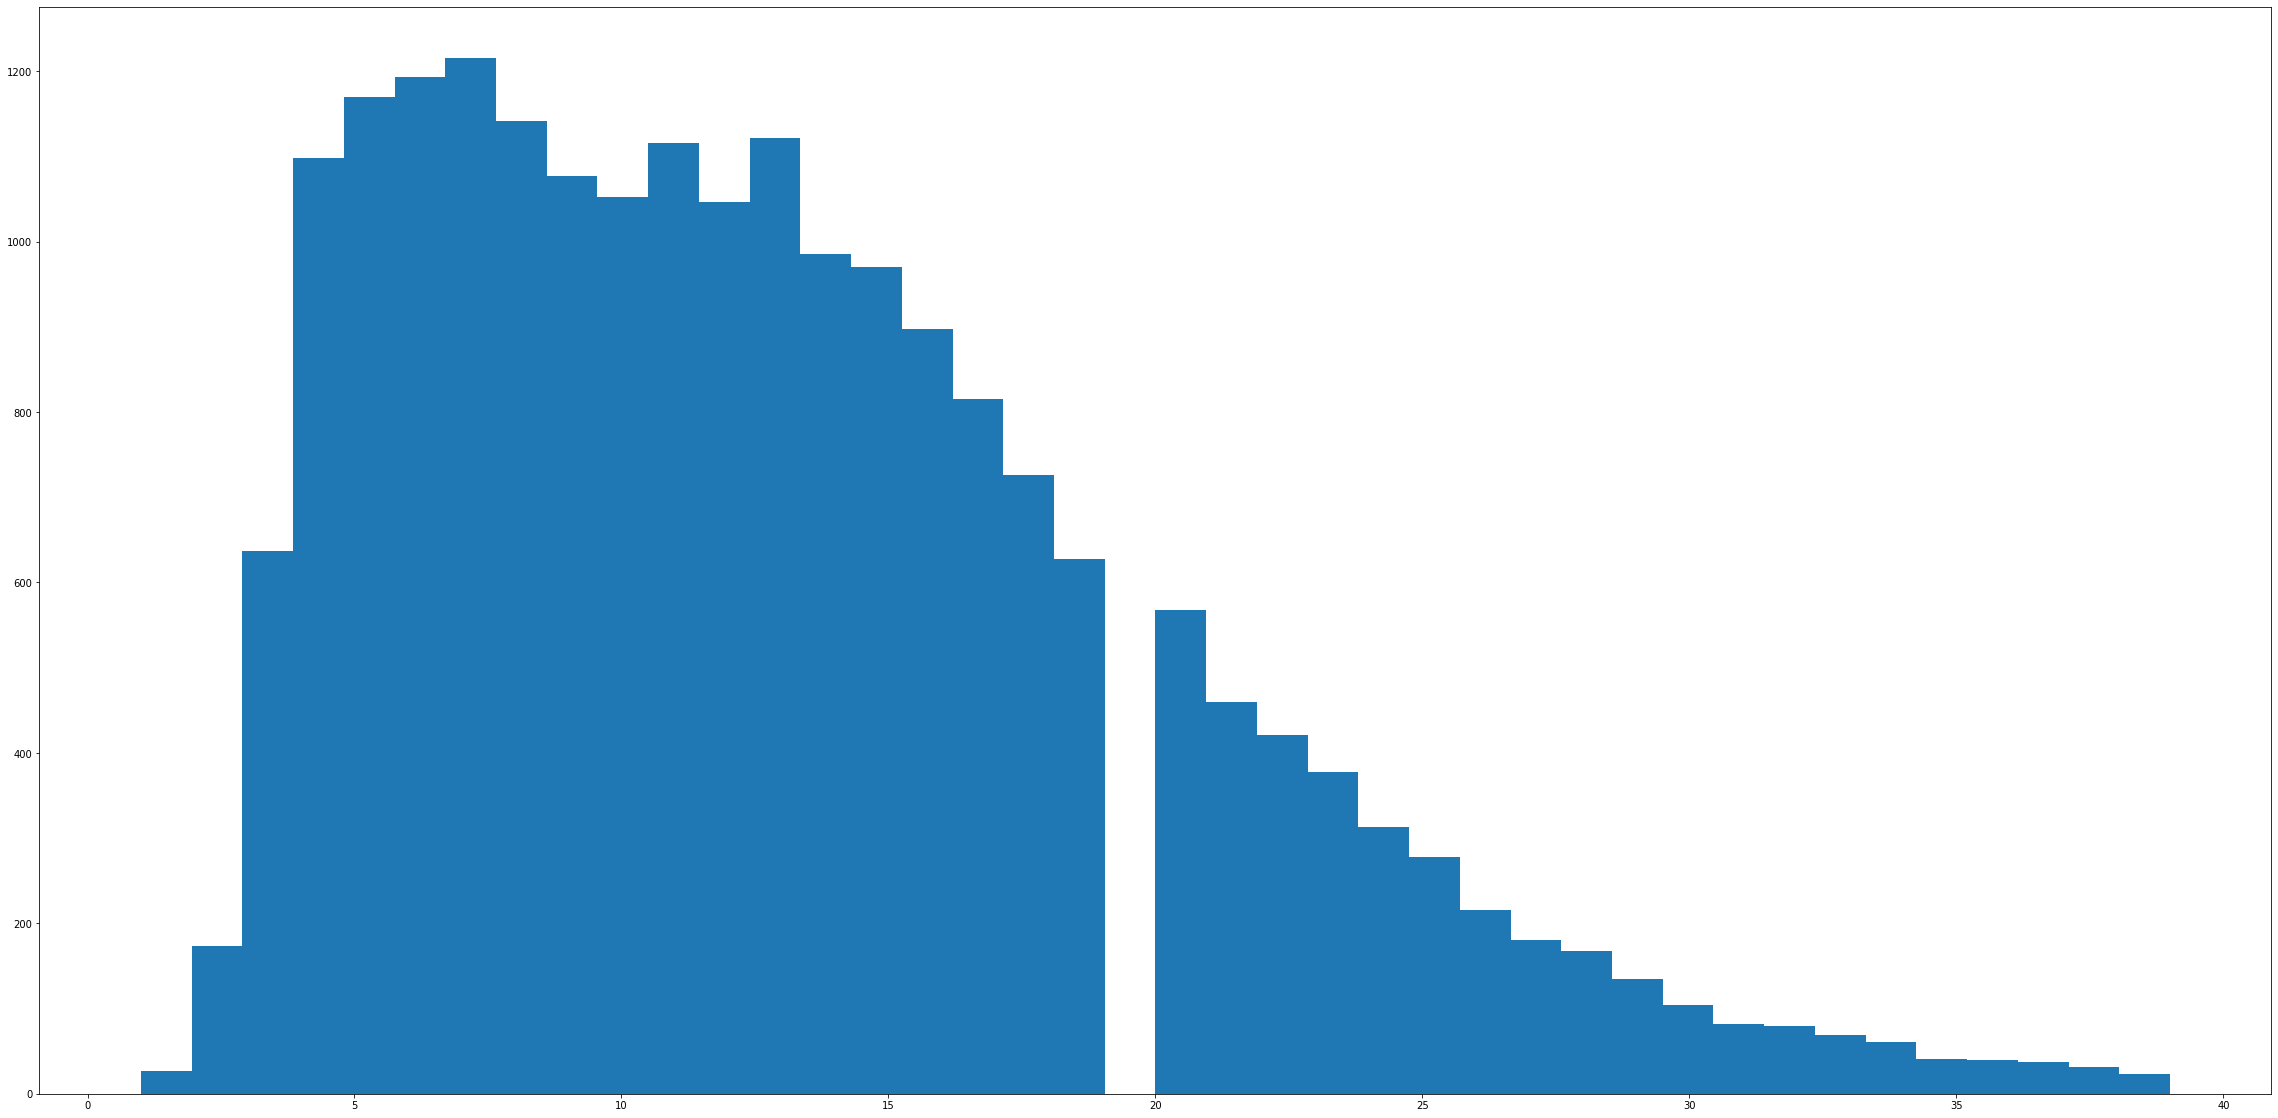

In [5]:
train_set = train_text.apply(preprocess)
train_set, train_labels_set = filter_words(train_set, train_label)

train_labels_set = np.array(train_labels_set)

def median(data):
    data.sort()
    mid = len(data) // 2
    return (data[mid] + data[~mid]) / 2

# visualize dataset
word_count = [len(sen) for sen in train_set]
print(f"min amount of words: {min(word_count)}\nmax amount of words: {max(word_count)}")
print(f"median amount of words: {median(word_count)}\nsentences: {len(word_count)}")
print(f"filtered words: {wordCountPreFilter - len(train_set)}")
plt.figure(figsize = (40,20))
plt.hist(word_count, bins = 40)

train_set = np.array([vectorization(sen) for sen in train_set])

In [6]:
# prepare validation data
valSet = pd.read_csv("data/disaster_response_messages_validation.csv")
valText = valSet["message"]
valLen = len(valSet["message"])
valLabels =  valSet[valSet.columns[7:]]
valText, valLabels = prepare_data(valText, valLabels)
print(f"filtered words: {valLen - len(valText)}")


def multi_label_accuracy(pred, true):
    predLs, trueLs = list(pred), list(true)
    return sum([predVal == trueLs[i] for i,predVal in enumerate(list(predLs))]) / len(predLs)

filtered words: 36


In [17]:
model = keras.Sequential([
    layers.LSTM(64, input_shape = (MAXLEN,50)),
    layers.Dense(32),
    layers.Dense(16),
    layers.Dense(35, activation = "sigmoid")
])


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 35)                595       
Total params: 32,643
Trainable params: 32,643
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["binary_accuracy"])

model.fit(train_set, train_labels_set, 
          epochs = 8, 
          validation_data = (valText, valLabels))

Epoch 1/8
650/650 [==============================] - 2s 2ms/step - loss: 0.2216 - binary_accuracy: 0.9228 - val_loss: 0.1851 - val_binary_accuracy: 0.9368
Epoch 2/8
650/650 [==============================] - 1s 2ms/step - loss: 0.1766 - binary_accuracy: 0.9398 - val_loss: 0.1653 - val_binary_accuracy: 0.9442
Epoch 3/8
650/650 [==============================] - 1s 2ms/step - loss: 0.1617 - binary_accuracy: 0.9453 - val_loss: 0.1557 - val_binary_accuracy: 0.9479
Epoch 4/8
650/650 [==============================] - 1s 2ms/step - loss: 0.1540 - binary_accuracy: 0.9481 - val_loss: 0.1503 - val_binary_accuracy: 0.9495
Epoch 5/8
650/650 [==============================] - 1s 2ms/step - loss: 0.1494 - binary_accuracy: 0.9494 - val_loss: 0.1499 - val_binary_accuracy: 0.9491
Epoch 6/8
650/650 [==============================] - 1s 2ms/step - loss: 0.1457 - binary_accuracy: 0.9507 - val_loss: 0.1462 - val_binary_accuracy: 0.9505
Epoch 7/8
650/650 [==============================] - 1s 2ms/step - los

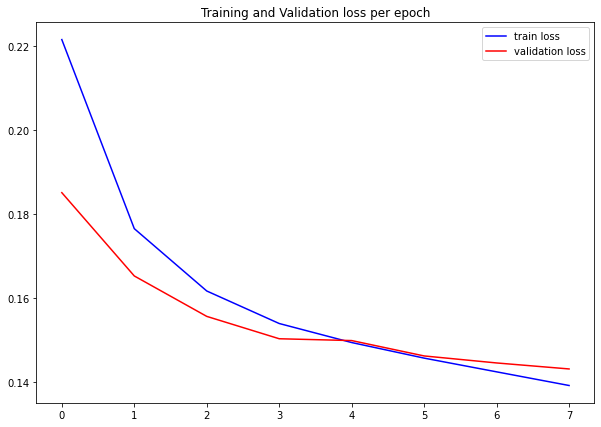

In [19]:
# plot loss
trainLoss = model.history.history["loss"]
valLoss = model.history.history["val_loss"]

plt.figure(figsize= (10,7))
plt.plot(trainLoss, "b", label = "train loss")
plt.plot(valLoss, "r", label = "validation loss")
plt.title("Training and Validation loss per epoch")
plt.legend()

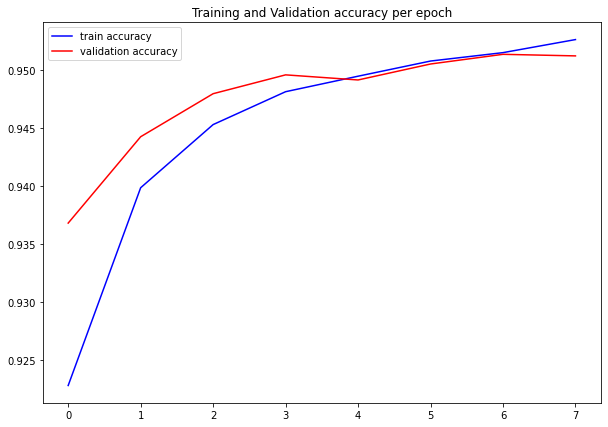

In [20]:
# plot accuracy
trainAcc = model.history.history["binary_accuracy"]
valAcc = model.history.history["val_binary_accuracy"]

plt.figure(figsize= (10,7))
plt.plot(trainAcc, "b", label = "train accuracy")
plt.plot(valAcc, "r", label = "validation accuracy")
plt.title("Training and Validation accuracy per epoch")
plt.legend()

In [21]:
#prepare test data
testSet = pd.read_csv("data/disaster_response_messages_test.csv")
print(len(testSet))
testText = testSet["message"]
testLabel = testSet[testSet.columns[7:]]
testText, testLabel = prepare_data(testText, testLabel)

2629


In [22]:
model.evaluate(testText, testLabel)

82/82 [==============================] - 0s 1ms/step - loss: 0.1397 - binary_accuracy: 0.9578


[0.1397114247083664, 0.9578282237052917]

## Generating plots for evaluation

In [23]:
# get predictions of model(cell takes a long time)
predictions = [model.predict(np.expand_dims(text, 0)) for text in testText]

Threshold with maximal accuracy: 198


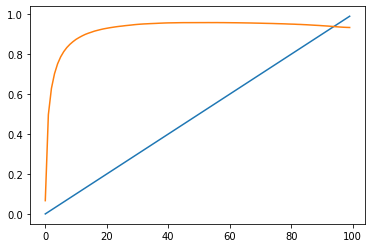

In [48]:
# plot accuracy vs set threshold
def acc_with_threshold(THRESHOLD):
    predictedLabels = [[int(p > THRESHOLD) for p in pred[0]] for pred in predictions]
    acc = 0
    for i,pred in enumerate(predictedLabels):
        acc += sum([int(p == testLabel[i][j]) for j,p in enumerate(pred)]) / len(pred)
    return acc / len(predictedLabels)

acc = [(THRESSHOLD/100, acc_with_threshold(THRESSHOLD/100)) for THRESSHOLD in range(0,100,1)]


Threshold with maximal accuracy: 0.53


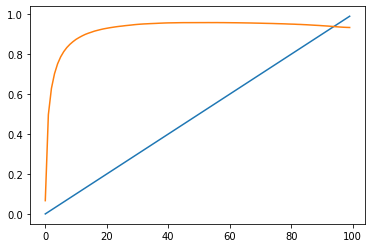

2605

In [80]:
from operator import itemgetter
THRESHOLD = max(acc,key=itemgetter(1))[0]

print(f"Threshold with maximal accuracy: {THRESHOLD}")
plt.plot(acc)
plt.show()

predictedLabels = [[int(p > THRESHOLD) for p in pred[0]] for pred in predictions]
len(predictedLabels)

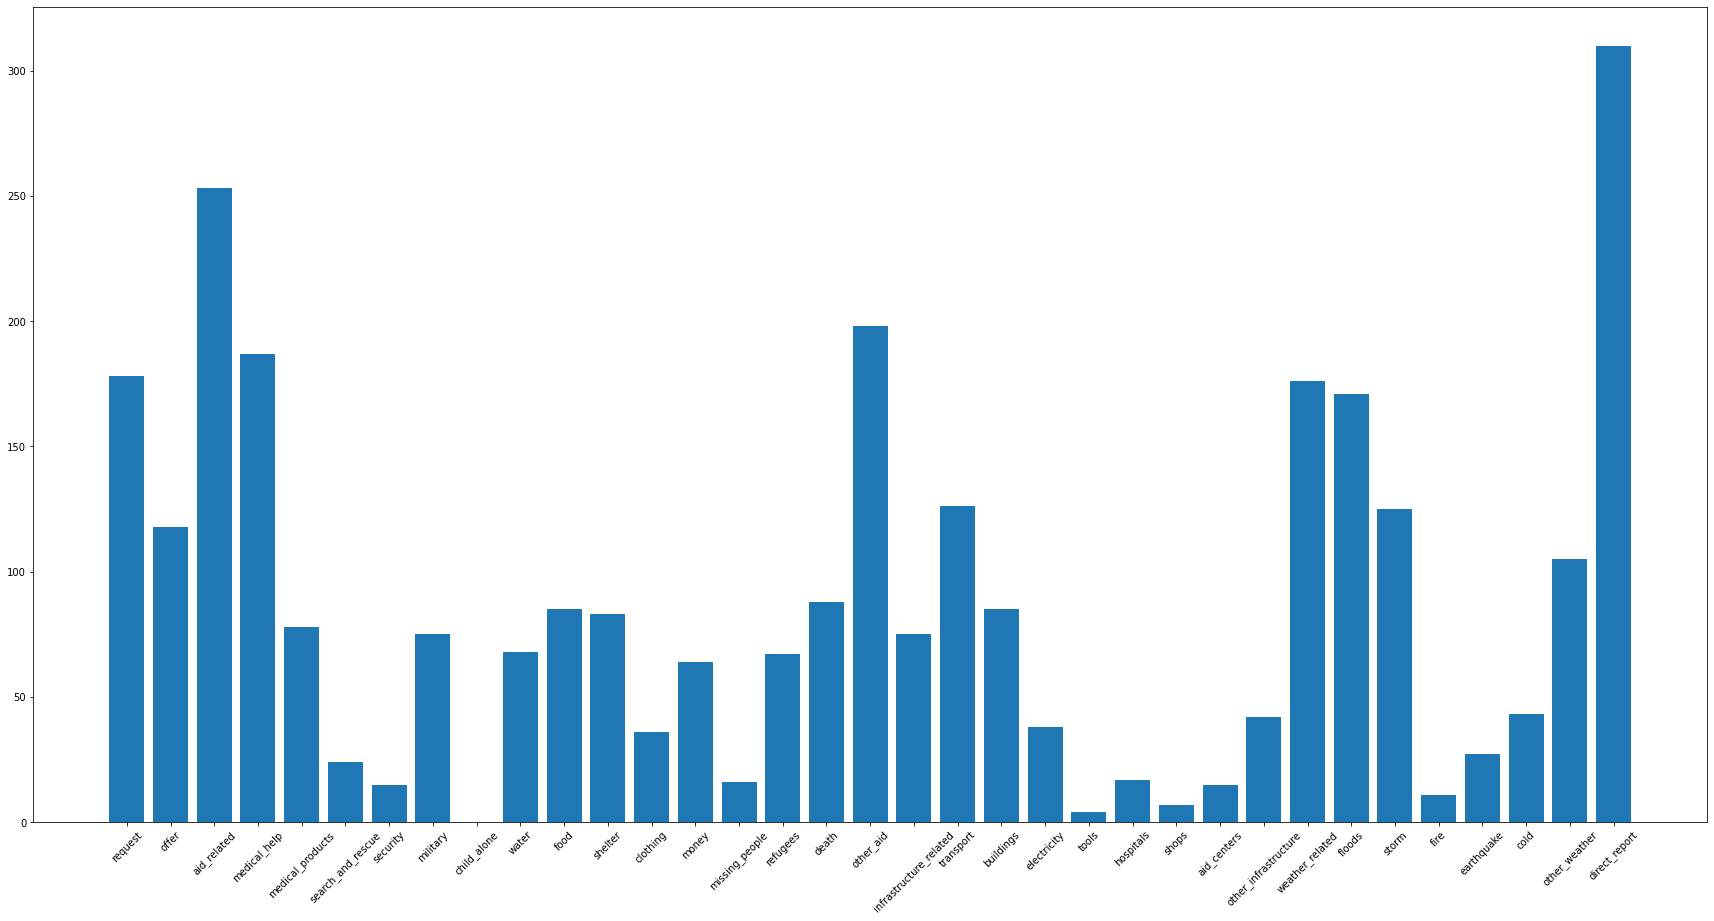

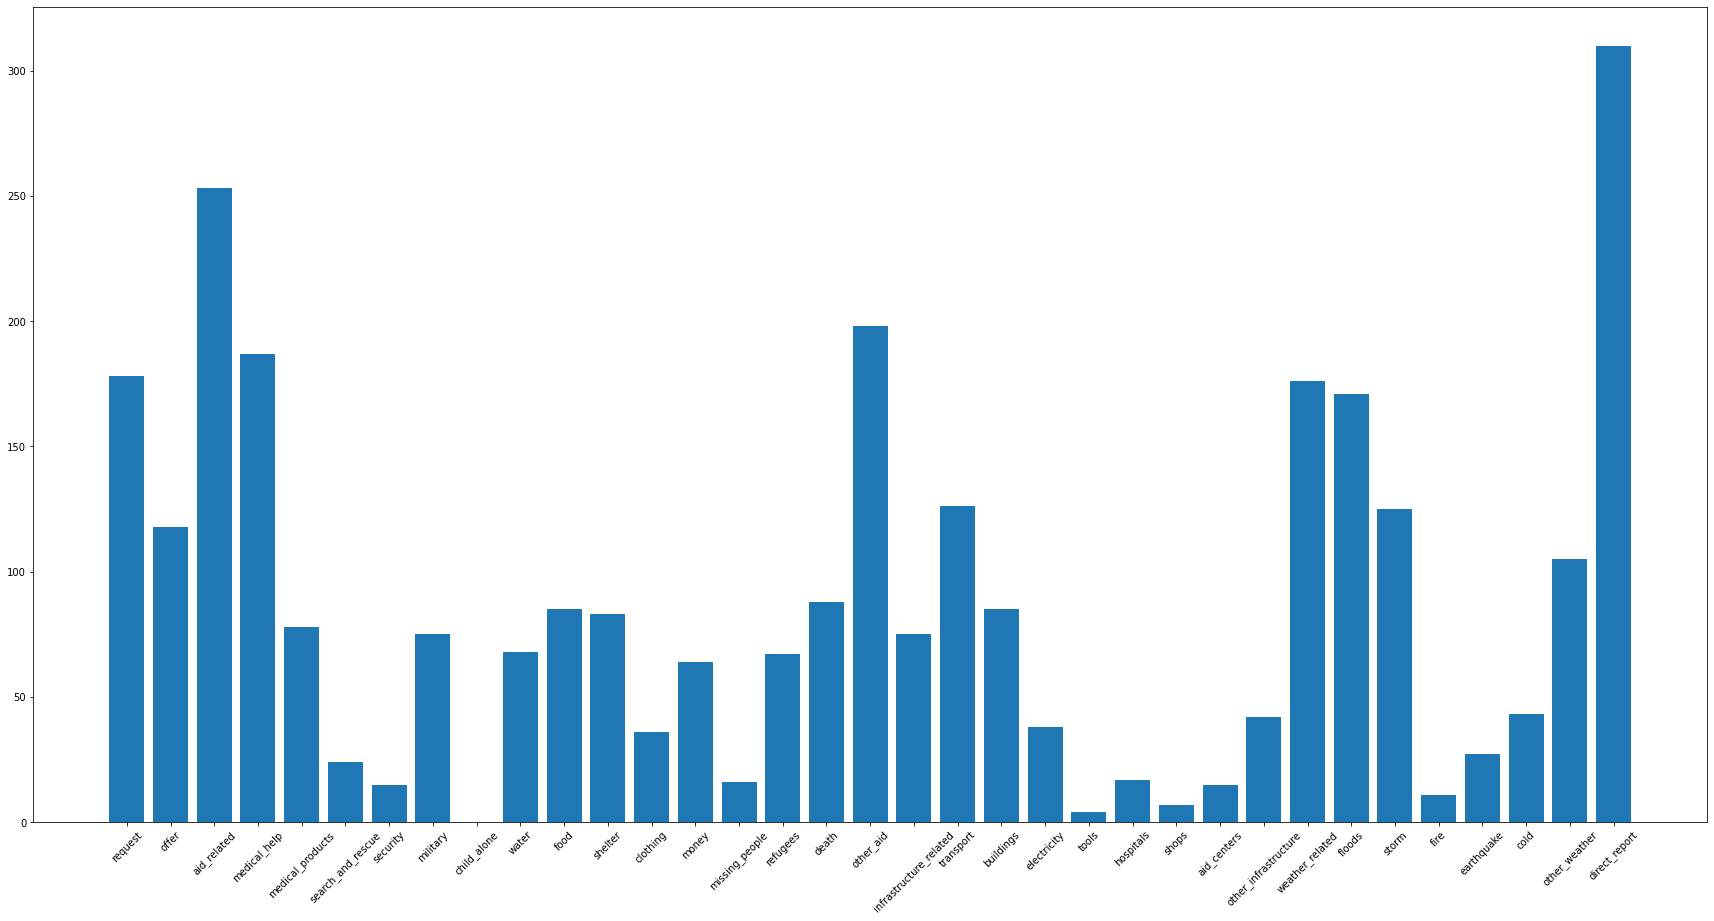

In [83]:
# plot Errors per label
falseNegativesPerLabel = {label:0 for label in testSet.columns[7:]}
falsePositivesPerLabel = {label:0 for label in testSet.columns[7:]}

for i, pred in enumerate(predictedLabels):
    for j,label in enumerate(testSet.columns[7:]):
        if pred[j] != testLabel[i][j]:
            if testLabel[i][j]:
                falseNegativesPerLabel[label] += 1
            else:
                falsePositivesPerLabel[label] += 1
                
plt.figure(figsize = (30,15))
plt.bar(falseNegativesPerLabel.keys(), falseNegativesPerLabel.values())
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.show()
plt.figure(figsize = (30,15))
plt.bar(falsePositivesPerLabel.keys(), falseNegativesPerLabel.values())
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.show()

<ipython-input-82-b4fc96c947c7>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,7))


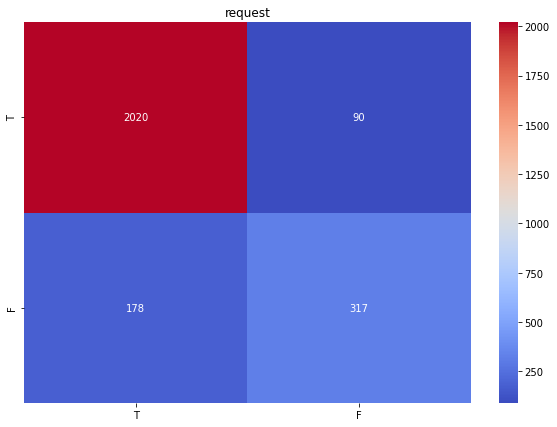

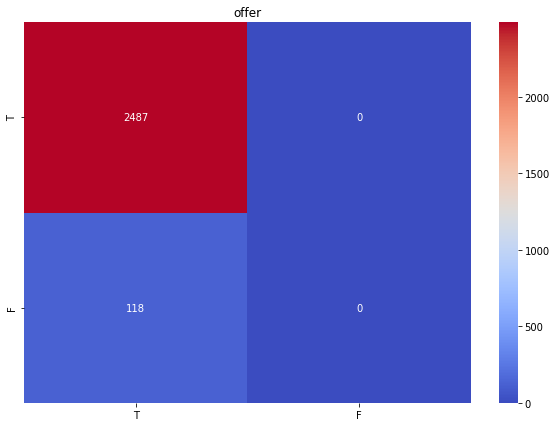

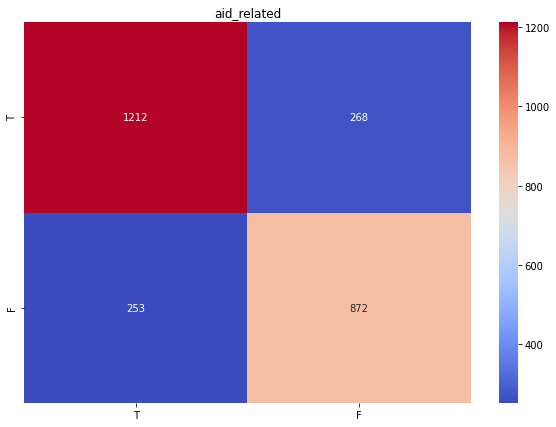

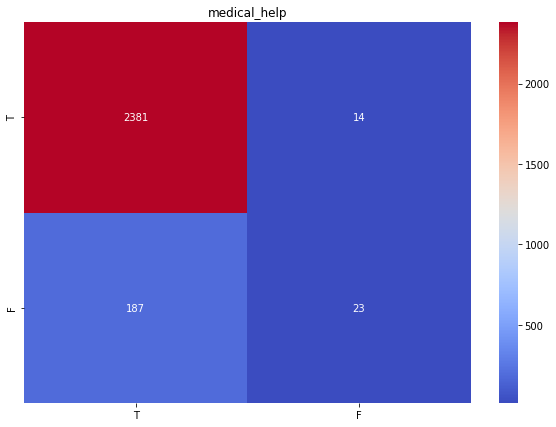

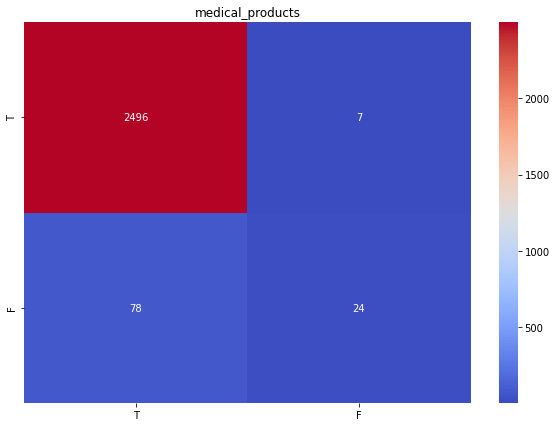

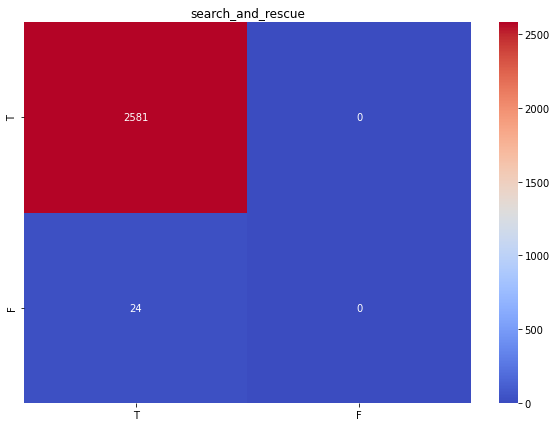

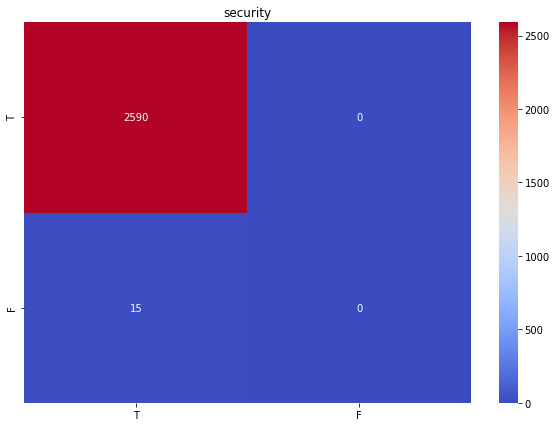

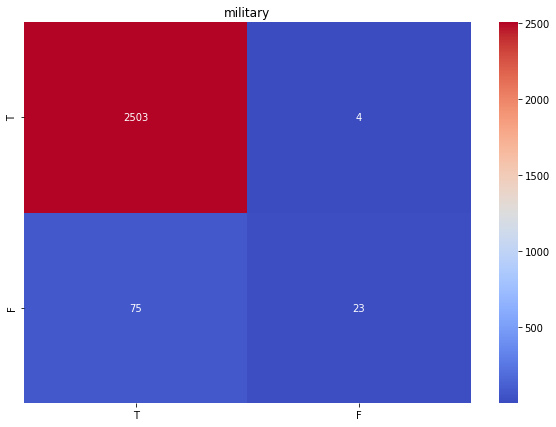

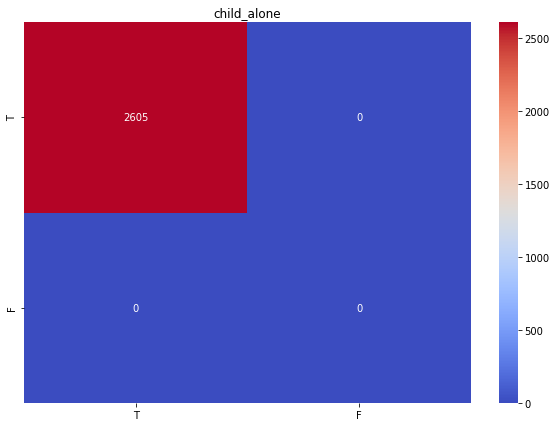

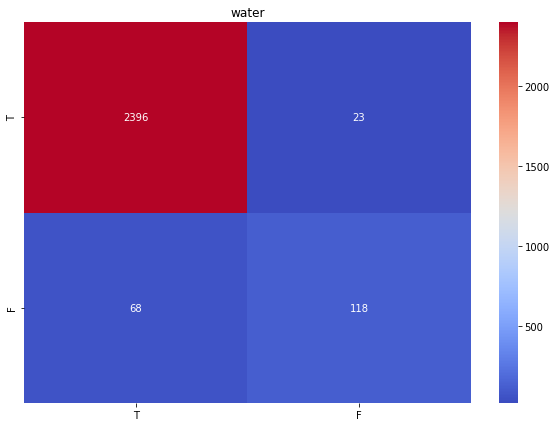

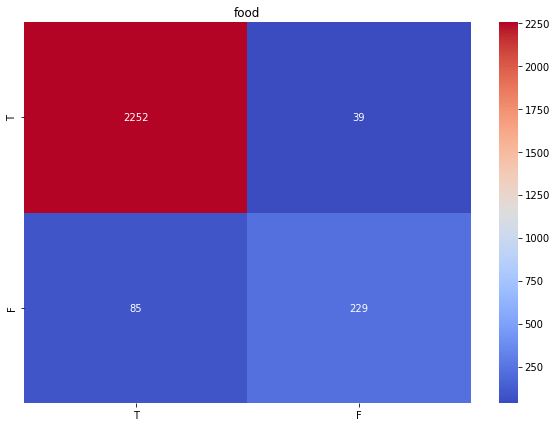

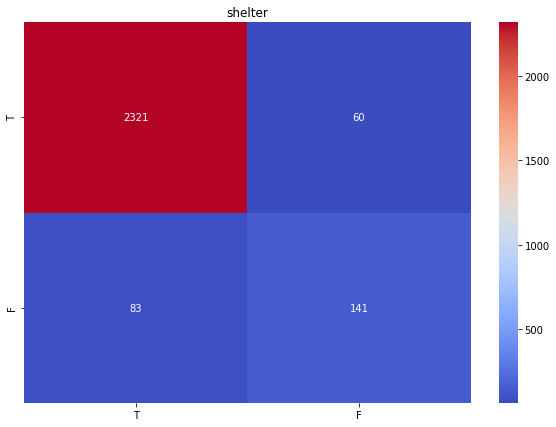

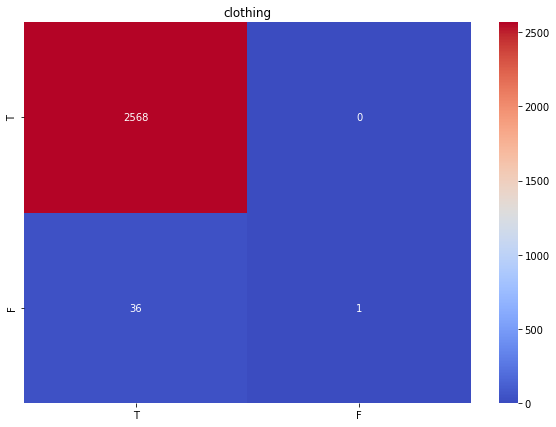

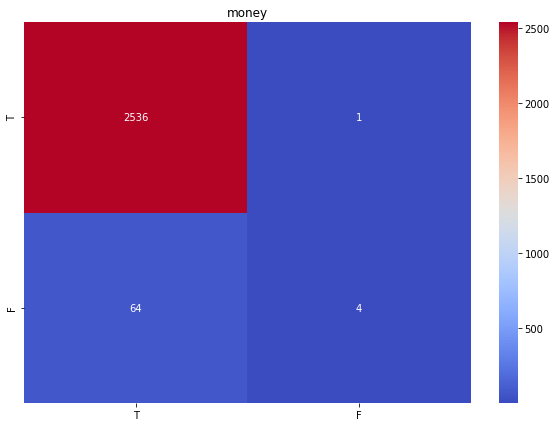

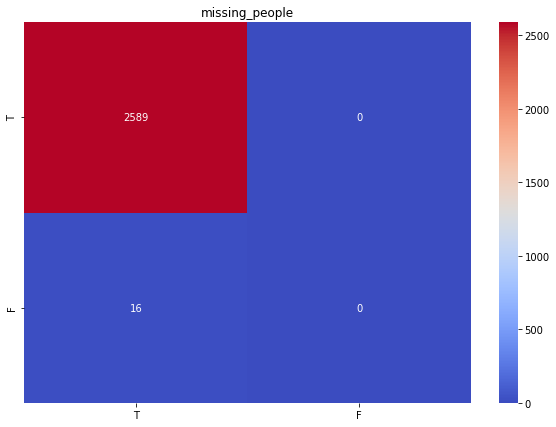

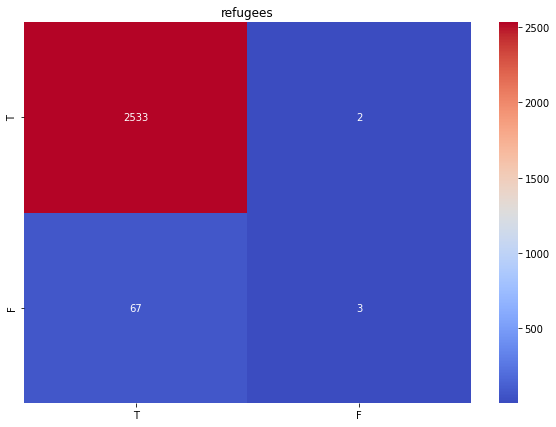

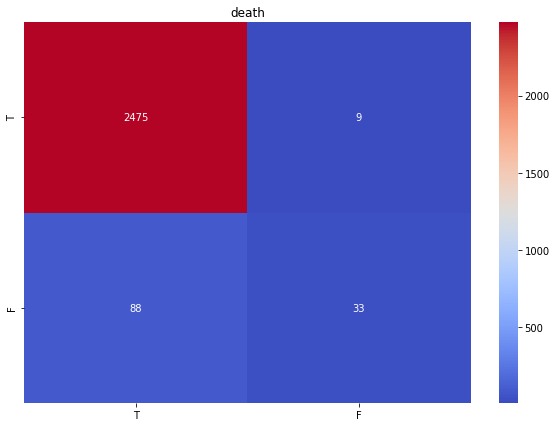

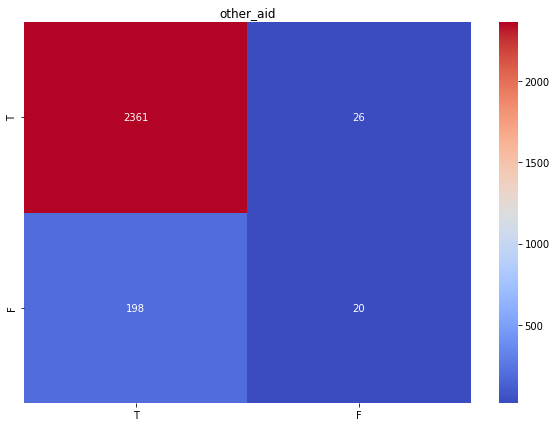

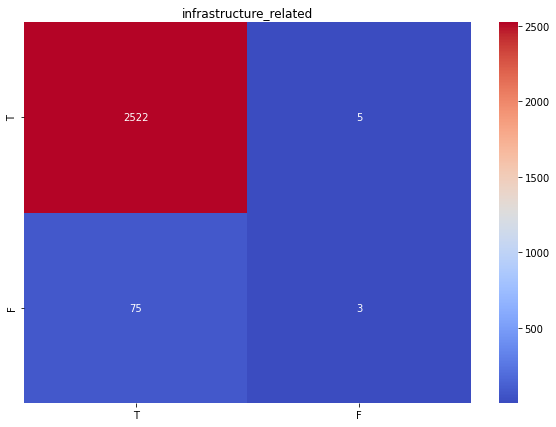

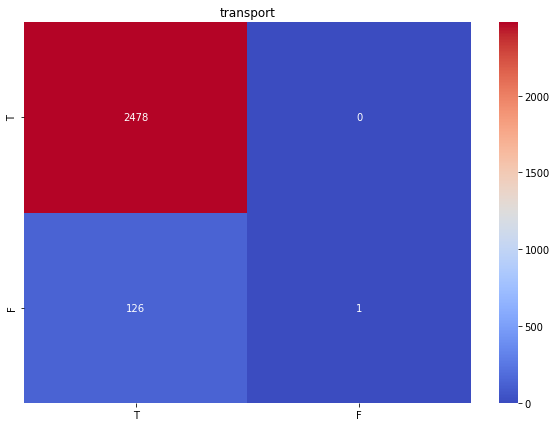

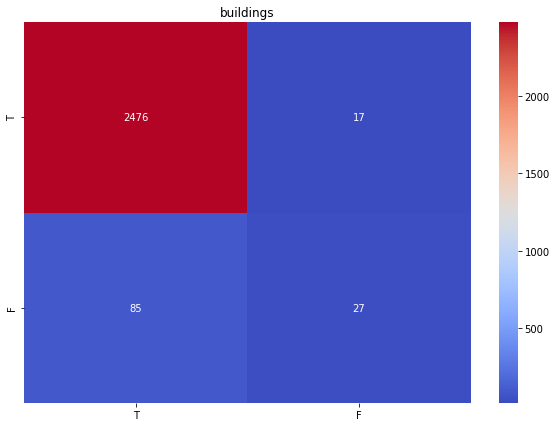

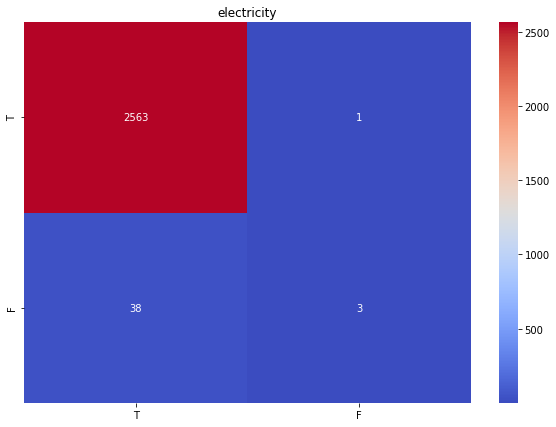

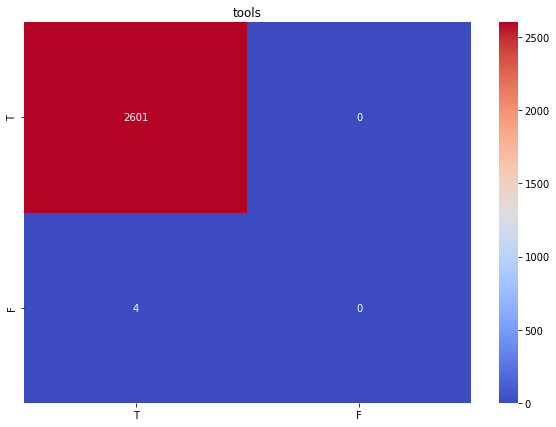

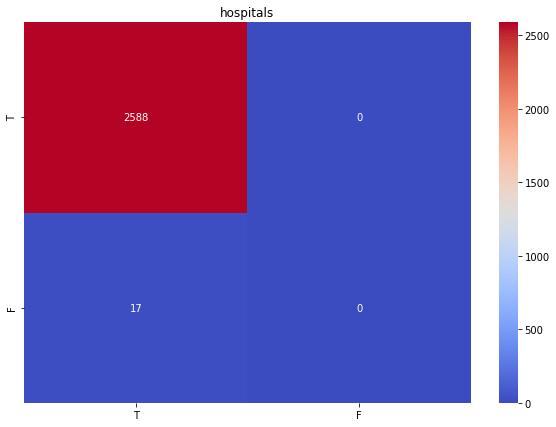

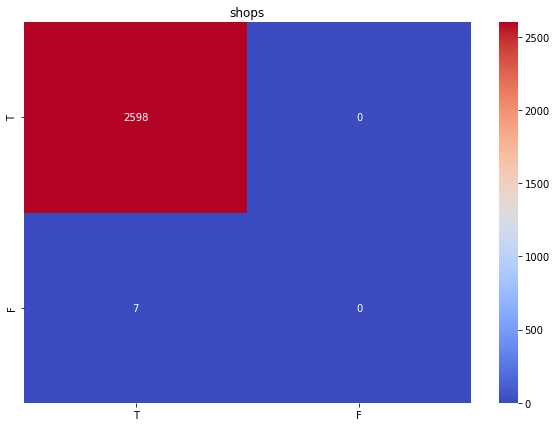

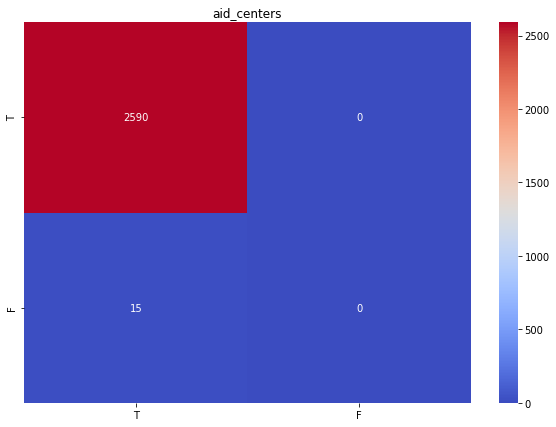

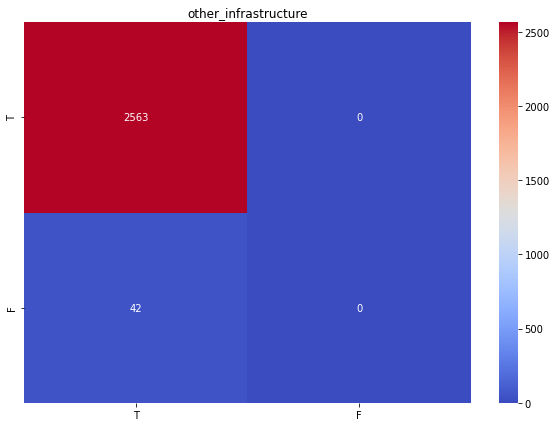

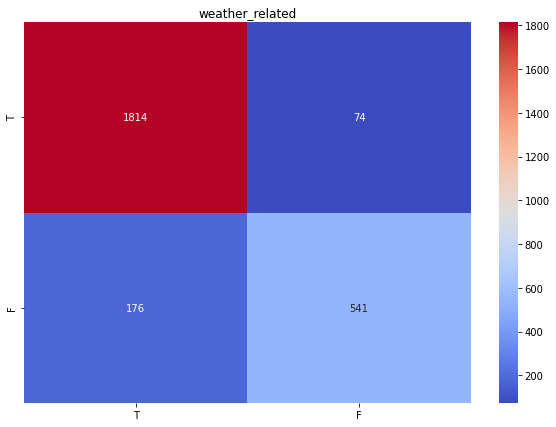

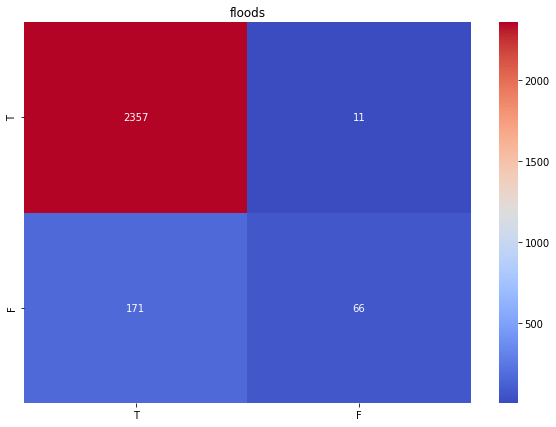

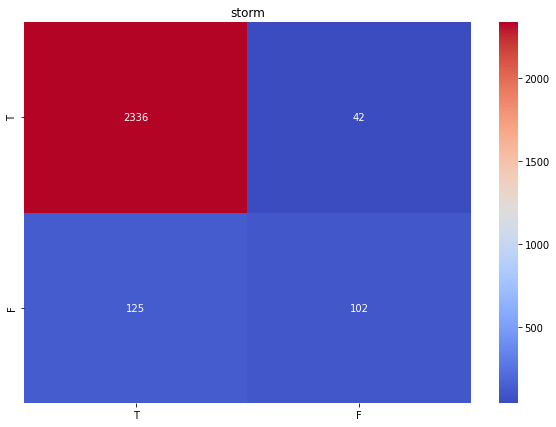

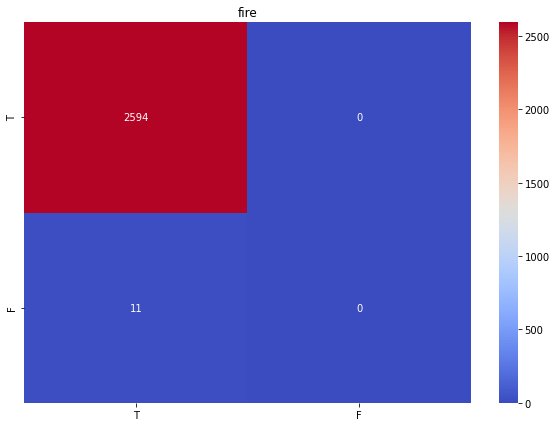

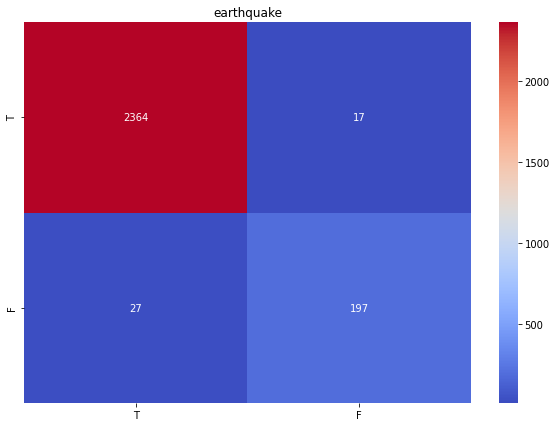

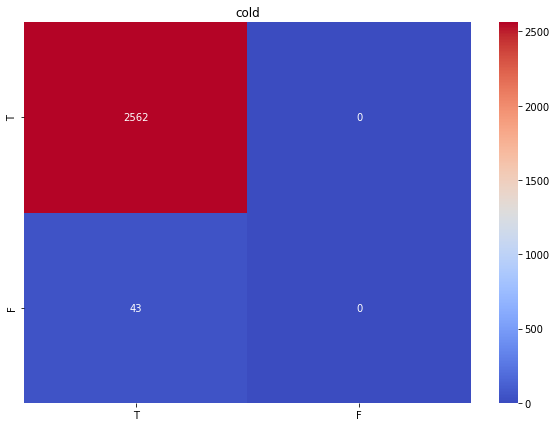

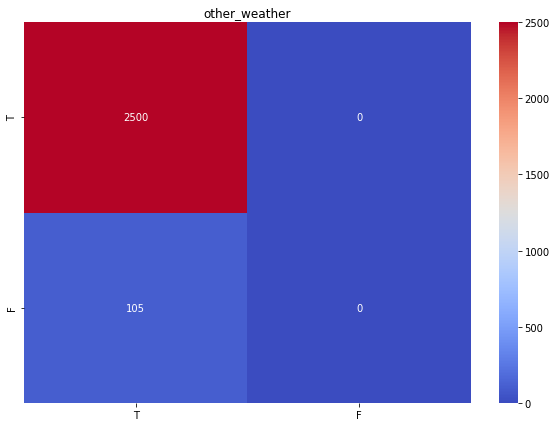

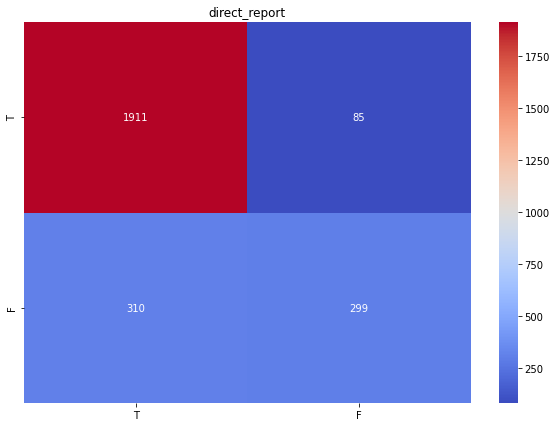

In [82]:
# multilabel confusion matrix
columns = testSet.columns[7:]
from sklearn.metrics import multilabel_confusion_matrix
conMat = multilabel_confusion_matrix(testLabel, predictedLabels)
for i,mat in enumerate(conMat):
    df_cm = pd.DataFrame(mat, index = ["T","F"],
                  columns = ["T","F"])
    plt.figure(figsize = (10,7))
    ax = sn.heatmap(df_cm, annot=True, fmt='.5g', cmap="coolwarm")
    ax.set_title(columns[i])

In [113]:
# plot metrics per label
TPperLabel = {label: conMat[i][0][0] for i,label in enumerate(columns)}
TNperLabel = {label: conMat[i][1][1] for i,label in enumerate(columns)}
FPperLabel = {label: conMat[i][1][0] for i,label in enumerate(columns)}
FNperLabel = {label: conMat[i][0][1] for i,label in enumerate(columns)}

precisionPerLabel = {label: TPperLabel[label]/(TPperLabel[label] + FPperLabel[label]) 
                     for label in columns}
recallPerLabel = {label: TPperLabel[label] / (TPperLabel[label] + FNperLabel[label])
                 for label in columns}
F1PerLabel = {label: 2 / (1/precisionPerLabel[label] + 1/recallPerLabel[label]) 
              for label in columns}

plot_vals = {label: [
    precisionPerLabel[label],
    recallPerLabel[label],
    F1PerLabel[label]
] for label in columns}

<AxesSubplot:>

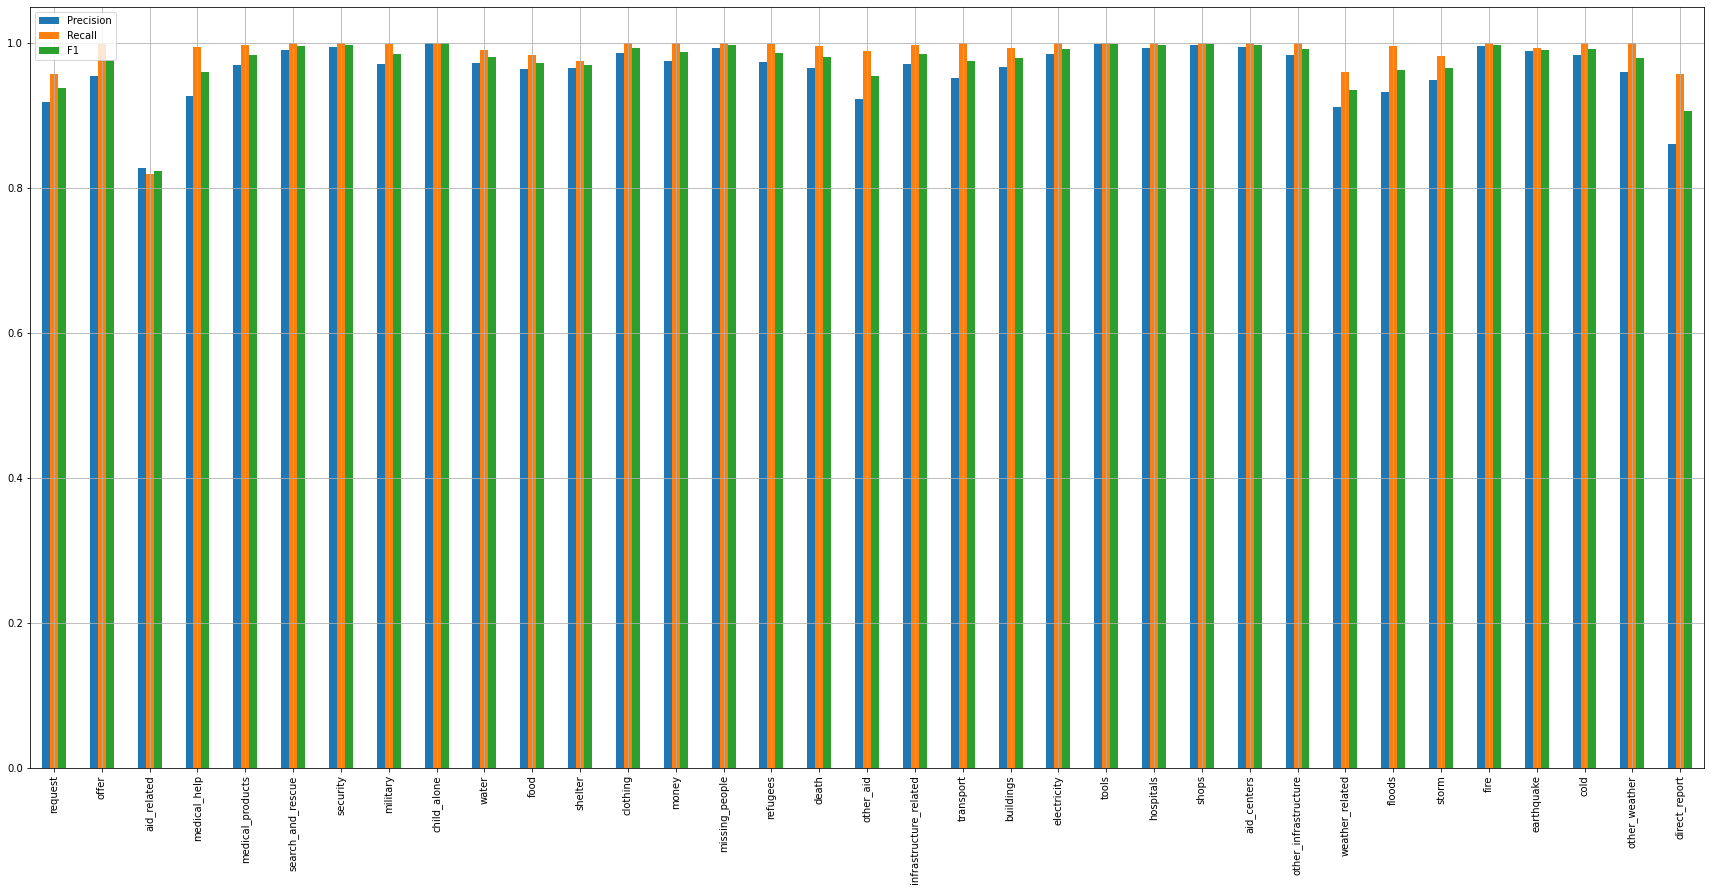

In [126]:
df = pd.DataFrame(plot_vals.values(), index = plot_vals.keys(), 
                  columns = ["Precision", "Recall", "F1"])
df.plot.bar(figsize = (30,14), grid = True)

In [25]:
# save model
model.save("Multi_Intent_Model")

INFO:tensorflow:Assets written to: Multi_Intent_Model/assets


INFO:tensorflow:Assets written to: Multi_Intent_Model/assets
